<a href="https://colab.research.google.com/github/dcolinmorgan/LTCOPDsex/blob/master/LTCOPD_TS_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LTCOPD dataset analyzed for time series prediction

In [2]:
!pip install GEOparse

     |████████████████████████████████| 286kB 2.8MB/s 
  Created wheel for GEOparse: filename=GEOparse-2.0.2-cp36-none-any.whl size=28845 sha256=a00c5e3969cf1f5d3452ff62ef46335c114d3a13ce5410f590cac810291a2711
  Stored in directory: /root/.cache/pip/wheels/84/6e/b8/b6497c4f50bde2c3b3f195a470e1bc894312407656896dd6bc
Successfully built GEOparse


In [3]:
import os
# import s3fs
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
import gc
from scipy import stats
import seaborn as sns
from scipy.stats import zscore
import tensorflow as tf


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import GEOparse
gse = GEOparse.get_GEO(geo="GSE76925", destdir="./")

In [5]:
gpl = gse.gpls[next(iter(gse.gpls))]
data = gse.pivot_samples(values="VALUE")#, gpl=gpl, annotation_column="Symbol")
data.sort_index
pheno=gse.phenotype_data.rename(columns={'characteristics_ch1.0.age': 'age',"characteristics_ch1.1.Sex":"sex","characteristics_ch1.3.bmi":"bmi","characteristics_ch1.6.fev1.pp":"fev1","characteristics_ch1.4.packyears":"PY"})
# pheno[['age',"sex","bmi","fev1","PY"]].to_csv('pheno_data.txt',sep='\t',index=True,header=True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
illumina_labels=pd.read_csv('drive/My Drive/Colab Notebooks dcm/GPL10558_illumina_prb_loc.txt',sep='\t',index_col=0,header=None,names=['loc','symbol'])

Mounted at /content/drive


In [7]:

ALL=data.merge(illumina_labels,left_index=True,right_index=True)
ALL.index=ALL['symbol']
# FEMALE=FEMALE[FEMALE['loc']!='Y']
del ALL['symbol'], ALL['loc']
ALL.columns=[np.round(gse.phenotype_data['characteristics_ch1.0.age'].astype('float'),0).astype('object').astype(str)]
ALL=ALL.groupby(by=ALL.columns, axis=1).median()

ALL.columns=[42, 44, 48, 50, 52, 53,54, 55, 56, 57, 58, 59,60, 61, 62, 63, 64, 65,66, 67, 68, 69, 70, 71,72, 73, 74, 75, 76, 77,78, 82, 84, 86]

ALL[49]=np.nan
ALL[51]=np.nan

# ALL[79]=np.nan
# ALL[80]=np.nan
# ALL[81]=np.nan
# ALL[83]=np.nan
# ALL[85]=np.nan
# ALL = ALL.reindex(sorted(ALL.columns), axis=1)
ALL = ALL.reindex(sorted(ALL.columns,reverse=True), axis=1) ##reverse order to predict younger expression


In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # plt.legend('best')
    plt.grid(True)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
tdata=pd.DataFrame(ALL.T, index=ALL.columns)#.interpolate(method='time')
tdata['Datetime'] = pd.to_datetime('19'+(ALL.columns.astype(str)) + ' ' +'10:00:00 ')
tdata = tdata.set_index('Datetime')
# ALL.iloc[1,:].to_list()#.dropna(how='any')
tdata=tdata.interpolate(method='time')
ttdata=tdata.T
# ALL#[:split_time].tolist().strip('F')
# FEMALE.columns=[42, 48, 50, 52, 53, 54,55, 56, 57, 58, 59, 60,61, 62, 63, 64, 65, 66,67, 68, 69, 70, 71, 72,73, 74, 75, 76, 77, 78,82, 84, 86]
# time=[42, 48, 50, 52, 53, 54,55, 56, 57, 58, 59, 60,61, 62, 63, 64, 65, 66,67, 68, 69, 70, 71, 72,73, 74, 75, 76, 77, 78,82, 84, 86]

MAE for EEF1A1 is 102.93192
MAE for GAPDH is 0.022043211
MAE for SLC35E2 is 0.13561939
MAE for EFCAB1 is 0.17530827
MAE for RPS28 is 0.6947992
MAE for IPO13 is 0.05812074
MAE for LOC653113 is 0.42870203
MAE for GGT1 is 0.8858854


KeyboardInterrupt: ignored

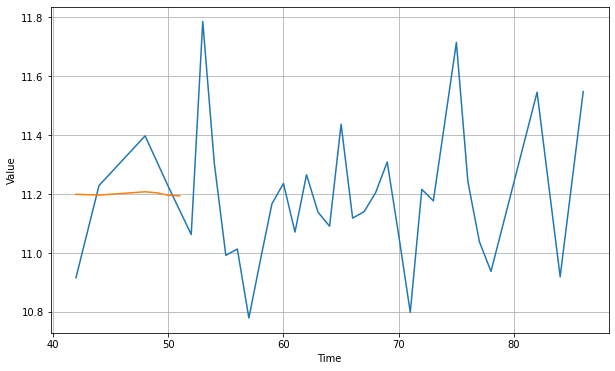

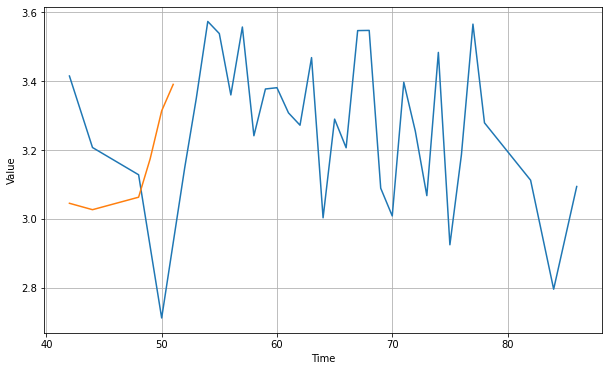

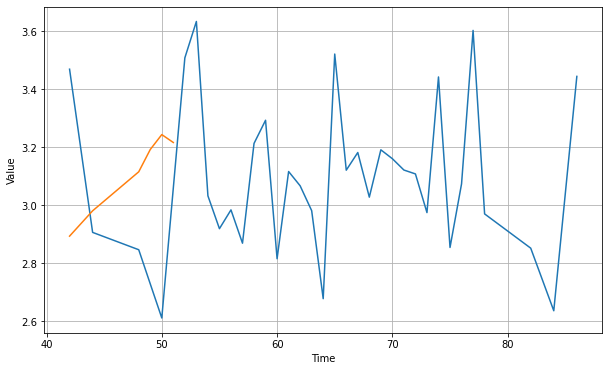

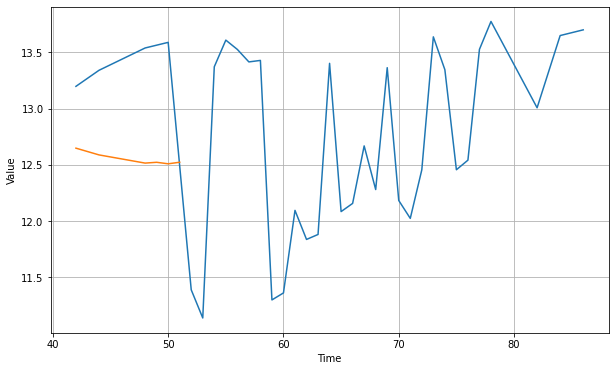

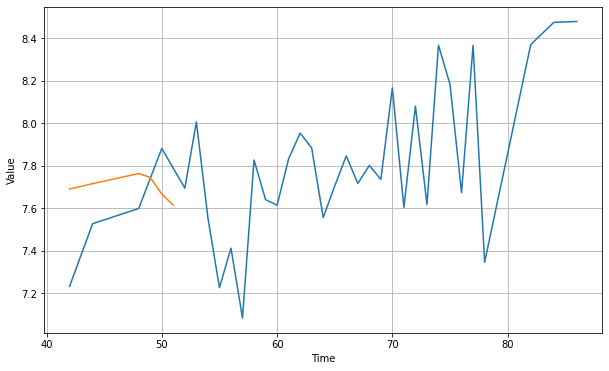

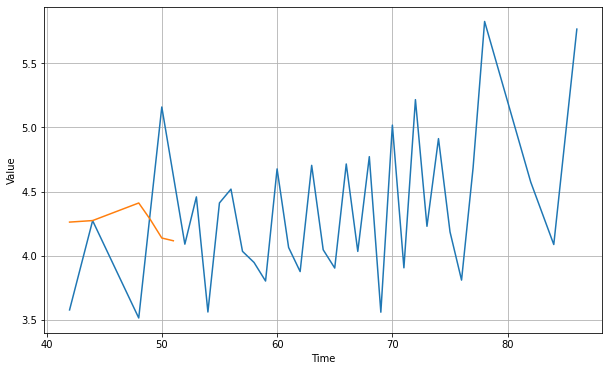

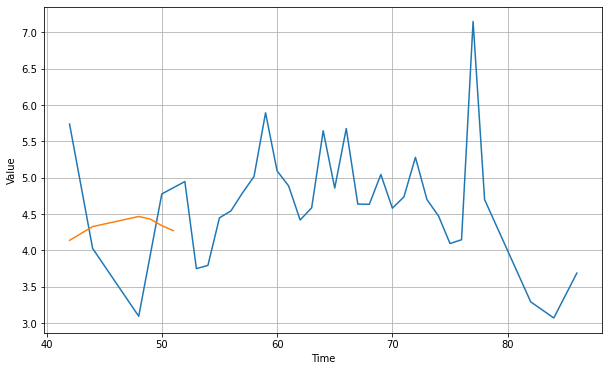

In [16]:
split_time = 30
heat=pd.DataFrame()
window_size = 5
batch_size = 5
shuffle_buffer_size = 1000


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(128, activation="relu", input_shape=[window_size]),
#   tf.keras.layers.Dropout(0.1),
#   tf.keras.layers.Dense(128, activation="relu"),
#   tf.keras.layers.Dropout(0.1),
#   tf.keras.layers.Dense(1),#,activation="sigmoid"),
# ])
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    # lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
# model.compile(metrics="mse", loss=tf.keras.losses.Huber(), ##less sensitive to outliers
#               optimizer=optimizer)
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(1),
  # tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])

# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])

for i in range(len(ttdata[0:50])):  ##per gene
  series=np.array(ttdata.iloc[i,:])

  time_train = ALL.columns[:split_time]
  x_train = series[:split_time]
  time_valid = ALL.columns[split_time:]
  x_valid = series[split_time:]
  dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

  # history = model.fit(dataset, epochs=500, verbose=0)
  # history = model.fit(dataset, epochs=100,  verbose=0,callbacks=[lr_schedule])
  history = model.fit(dataset,epochs=500,verbose=0)

  loss = history.history['loss']
  epochs = range(len(loss))
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

  forecast = forecast[split_time-window_size:]
  results = np.array(forecast)[:, 0, 0]
  cc=tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

  if cc<2:
    plt.figure(figsize=(10, 6))
    print('MAE for '+ttdata.index[i]+ ' is '+str(cc))
    plot_series(np.append(time_train,time_valid), np.append(x_train,x_valid))
    plot_series(time_valid, results)
    
  else:
    print('MAE for '+ttdata.index[i]+ ' is '+str(cc))
  Col1=ttdata.index[i]
  Col2=cc
  column = [Col1, Col2]
  column=np.transpose(pd.DataFrame((column)))
  column.to_csv('drive/My Drive/Colab Notebooks dcm/LTCOPD_LSTM_pred40-45.txt',mode='a',header=False,index=False)
  heat=pd.concat([heat,column],axis=0)